# BookBeat Booklist Webscraping and Sentiment Analysis

Scrapes the book description webpages on the [BookBeat Sweden website](www.BookBeat.se), extracting the `title`, `rating`, `description`, and `reviews` of each book, then conducts a sentimental analysis rating may be helpful to giving the user more relevant book recommendations, leading to higher engagement.

## Method
1. Goes to the [BookBeat Sweden website](www.BookBeat.se) 
2. Goes to a specified booklist category page—such as [Fantasy](https://www.bookbeat.se/kategori/science-fiction-46024)—and uses `BeautifulSoup` and `Selenium` to scrape all of the urls of the individual books—such as [Harry Potter](https://www.bookbeat.se/bok/harry-potter-och-fenixorden-86333)—saving them to a `csv` file.
3. Then uses the `booklinks.csv` file to automatically click on every individual link and extract the `title`, `rating`, `description`, and `reviews`, and saves them to a pandas dataframe.
4. Then conducts a `sentment analysis` of the reviews, using the `nltk` library, to transform each review into a quantifiable metric. For example:
    - "I love this book!" would have a 1.0 rating, 
    - "It sucks" would have a -1.0 rating, and
    - "I love the author, but this book wasn't her best." would have a -0.4501 rating.

## Limitations
- Most of the book reviews are in Swedish. The `nltk` library for sentiment analysis has limited support for Swedish, therefore, it's necessary to translate the Swedish reviews into English, leading to lost-in-translation problems as subtle nuance is lost, meaning the score won't be fully accurate.
- The automatic translation APIs cost money, so as a workaround, the Swedish reviews need to be manually copied and pasted, then sent to Google Sheets, and then translated with the GOOGLETRANSLATE() function, then copied back to the Pandas dataframe. Instructions provided.
- The books on the BookBeats website don't have many reviews (often < 10), meaning the average sentiment score of the reviews might not accurately reflext the mean of the population.

## Libraries

In [1]:
# Making HTML requests.
import requests

# Beautiful Soup Webscraping
from bs4 import BeautifulSoup

# Selenium Webscraping
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
import time

# Data Analysis
import pandas as pd
import numpy as np

# Sentiment Analyis
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Phase I: Webscraping

## Configuration Cell

In [5]:
# The root url of the BookBeat website.
root_url = "https://www.bookbeat.se"

# The booklist to scrape.
webpage_to_scrape = "https://www.bookbeat.se/kategori/fantasy-46020"

# Where to save csv file with links of all books in booklist.
booklinks_csv_file = "booklinks.csv"

##  Collecting Book Links


## `get_booklinks_from_webpage()`

In [6]:
def get_booklinks_from_webpage(webpage_to_scrape, output_filename, see_more=0):
    """
    Uses Selenium to
    1. go to thewebpage_to_scrape,
    2. click on 'Accept All Cookies'
    3. click on 'Visa Mer' (see more) a specified number of times
    Then uses Beautiful soup to
    - extract all book links on the page, then
    - store them onto a CSV file

    Parameters:
    webpage_to_scrape(str): The website to scrape.
    output_filename(str): The name of the CSV file where links will be stored.
    see_more(int): Number of times see more button will be clicked.
    """
    
    # Create Web Driver
    chrome_driver_path = r"C:\Program Files (x86)\chromedriver.exe"
    driver = webdriver.Chrome(executable_path=chrome_driver_path) # for PC

    # Open Webpage
    driver.get(url=webpage_to_scrape) 

    # Click on "Accept All Cookies Buttong"
    time.sleep(3)
    cookies_button = driver.find_element(By.XPATH, value='//*[@id="__next"]/div[1]/div[1]/div/div/button[1]')
    cookies_button.click()

    # Click on "See More Button"
    for click_see_more_button in range(see_more + 1):
        time.sleep(1)
        see_more_button = driver.find_element(By.XPATH, value='//*[@id="__next"]/div[1]/div/main/div[2]/div[2]/div/div/div[4]/button')
        see_more_button.click()

    # Get all HTML on site and store it in soup.
    soup = BeautifulSoup(driver.page_source, "html.parser")

    # Close the driver.
    driver.quit()

    # Convert soup into book links.
    book_links = [book.get('href') 
                for book in soup.find_all('a') 
                if book.get('href').startswith('/bok/')]

    # Store book_links in a CSV
    pd.DataFrame(book_links).to_csv(output_filename, 
                                    index=False, 
                                    header=False)

## Run `get_booklinks_from_webpage()` function.
- `see_more=1` will collect 150 book links.

CSV File in this format:
- /bok/harry-potter-och-fenixorden-86333
- /bok/harry-potter-and-the-order-of-the-phoenix-38063
- /bok/harry-potter-och-den-flammande-bagaren-86331

In [7]:
get_booklinks_from_webpage(webpage_to_scrape, booklinks_csv_file, see_more=1)

C:\Users\james\AppData\Local\Temp\ipykernel_9728\3043923931.py:19: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path=chrome_driver_path) # for PC


### Creating a `book_links` list.
Converting links on `booklinks.csv` file into a list which can be used for further operations.

In [8]:
with open(booklinks_csv_file) as file:
    book_links = [root_url + link.strip() for link in file]

print(book_links)

['https://www.bookbeat.se/bok/harry-potter-och-fenixorden-86333', 'https://www.bookbeat.se/bok/harry-potter-and-the-order-of-the-phoenix-38063', 'https://www.bookbeat.se/bok/harry-potter-och-den-flammande-bagaren-86331', 'https://www.bookbeat.se/bok/harry-potter-och-dodsrelikerna-86332', 'https://www.bookbeat.se/bok/harry-potter-and-the-deathly-hallows-38065', 'https://www.bookbeat.se/bok/harry-potter-and-the-goblet-of-fire-38062', 'https://www.bookbeat.se/bok/harry-potter-och-halvblodsprinsen-86330', 'https://www.bookbeat.se/bok/harry-potter-and-the-half-blood-prince-38064', 'https://www.bookbeat.se/bok/harry-potter-och-de-vises-sten-86287', 'https://www.bookbeat.se/bok/harry-potter-och-fangen-fran-azkaban-86329', 'https://www.bookbeat.se/bok/harry-potter-och-hemligheternas-kammare-86328', 'https://www.bookbeat.se/bok/harry-potter-and-the-prisoner-of-azkaban-38061', 'https://www.bookbeat.se/bok/en-krona-av-gyllene-ben-928417', "https://www.bookbeat.se/bok/harry-potter-and-the-philosop

## Scrape Individual Book Pages
- Selenium scrapes all html information from each link in `book_links`, storing the information on an `html_soup` list.

In [9]:
html_soup = []

# Create Web Driver
chrome_driver_path = r"C:\Program Files (x86)\chromedriver.exe"
driver = webdriver.Chrome(executable_path=chrome_driver_path) # for PC

# Open BookBeat homepage
driver.get(url=root_url)

# Click on "Accept All Cookies Buttong"
time.sleep(3)
cookies_button = driver.find_element(By.XPATH, value='//*[@id="__next"]/div[1]/div[1]/div/div/button[1]')
cookies_button.click()

for link in book_links:
    
    # Go to each individual book page.
    driver.get(url=link)

    # Click 'See More (visa mer) Button
    time.sleep(0.5)
    
    try:
        see_more_button = driver.find_element(By.CSS_SELECTOR, value='#__next > div.bb-app > div.layoutWithMenu_base___CUtP.bg_white__NNOg1 > main > section.common_fluid__JxoyD.bg_yellowTertiary__5qBrt.common_pagePadding__qy5mB.paddingTop_medium__MP5pf.paddingBottom_medium__r7vd4 > div > div > button')
        see_more_button.click()
    except NoSuchElementException:
        print("SEE MORE not found with ", link)

    # Extract HTML
    soup = BeautifulSoup(driver.page_source, "html.parser")

    html_soup.append(soup)

# Close the driver.
driver.quit()

C:\Users\james\AppData\Local\Temp\ipykernel_9728\2738559768.py:5: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path=chrome_driver_path) # for PC


SEE MORE not found with  https://www.bookbeat.se/bok/game-of-thrones-kungarnas-krig-552
SEE MORE not found with  https://www.bookbeat.se/bok/gyllene-sonen-16659
SEE MORE not found with  https://www.bookbeat.se/bok/a-storm-of-swords-25902
SEE MORE not found with  https://www.bookbeat.se/bok/tidens-hjul-19964
SEE MORE not found with  https://www.bookbeat.se/bok/magician-26869
SEE MORE not found with  https://www.bookbeat.se/bok/drakens-flykt-24587
SEE MORE not found with  https://www.bookbeat.se/bok/tomans-huvud-21266
SEE MORE not found with  https://www.bookbeat.se/bok/vindarnas-skal-54599
SEE MORE not found with  https://www.bookbeat.se/bok/royal-assassin-26425
SEE MORE not found with  https://www.bookbeat.se/bok/assassin's-apprentice-26437
SEE MORE not found with  https://www.bookbeat.se/bok/knivarnas-vag-59142
SEE MORE not found with  https://www.bookbeat.se/bok/assassin's-quest-26444
SEE MORE not found with  https://www.bookbeat.se/bok/den-onda-dagen-127546
SEE MORE not found with  

### Backup `html_soup`
`html_soup` is a giant list with the html scraped from possibly hundreds or thousands of websites. So that list is being saved onto html_soup.pkl just in case.

In [ ]:
# BACKUP with this code here.
# import pickle

# with open('html_soup.pkl', 'wb') as file:
#     pickle.dump(html_soup, file)

## RESTORE with this code here.
# with open('html_soup.pkl', 'rb') as file:
#     html_soup = pickle.load(file)

# Creating the Pandas DataFrame

### Extract Book Titles from html_soup

In [13]:
# Extract Titles
title_list = []
title_CSS_selector = "nuiHeader_inner__1Kl0C"

for soup in html_soup:

    element = soup.find(class_=title_CSS_selector)

    if element:
        title_list.append(element.text)
    else:
        title_list.append(np.NaN)

print(len(title_list), 'ELEMENTS')

150 ELEMENTS


### Extract description from html_soup

In [14]:
# Extract Description
description_list = []

CSS_selector = "p > span"

for soup in html_soup:

    element = soup.select(CSS_selector)[0]

    if element:
        description_list.append(element.text)
    else:
        description_list.append(np.NaN)

print(len(description_list), 'ELEMENTS')

150 ELEMENTS


### Extract ratings from html_soup

In [ ]:
# EXTRACT RATING
selector = "span + span"
rating_list = []


for soup in html_soup:

    # Gets the rating in the form of "Betyg 4.8"
    element = soup.select_one(selector=selector)
    
    if element:
        
        rating = element.text
        rating = float(rating.strip().replace("Betyg ", ""))
        rating_list.append(rating)

    else:
        rating_list.append(np.NaN)

## Get Reviews from html_soup

In [16]:
review_list = []
no_reviews = []

review_CSS_selector = "review_text__S3C6r"

for soup in html_soup:

    reviews = [review.text for review in soup.find_all(class_=review_CSS_selector)]

    review_list.append(reviews)

### Compile lists into a dictionary.

In [33]:
book_data = dict(zip(['title', 'rating', 'description', 'reviews_se', 'url'], 
                     [title_list, rating_list, description_list, review_list, book_links]))

## Convert dictionary to a Pandas DataFrame

In [34]:
book_data = pd.DataFrame(book_data)

In [35]:
book_data.head(3)

,title,rating,description,reviews_se,url
0,Harry Potter och Fenixorden,4.8,Harry Potter har fått nog. Sommarlovet hos Dur...,[Varje bok är en underbar dröm! Jag älskar kar...,https://www.bookbeat.se/bok/harry-potter-och-f...
1,Harry Potter and the Order of the Phoenix,4.8,'You are sharing the Dark Lord's thoughts and ...,"[Bättre böcker finns inte , 😍, Så bra ⚡️⚡️⚡️⚡️...",https://www.bookbeat.se/bok/harry-potter-and-t...
2,Harry Potter och Den Flammande Bägaren,4.8,En natt vaknar Harry Potter av att ärret i pan...,"[Bästa boken!!!, Väldigt bra lätt att somna ti...",https://www.bookbeat.se/bok/harry-potter-och-d...


## Save DataFrame to a CSV file.

In [36]:
# Save to CSV
book_data.to_csv("df.csv")

# Data Analysis

### Create DataFrame

In [22]:
df = pd.read_csv('df.csv')

# Cleaning up index and first column problem.
df = df.reset_index(drop=True)
if df.columns[0].startswith('Unnamed'):
    df = df.drop(df.columns[0], axis=1)

In [23]:
df.head(1)

,title,rating,description,reviews_se,url
0,Harry Potter och Fenixorden,4.8,Harry Potter har fått nog. Sommarlovet hos Dur...,['Varje bok är en underbar dröm! Jag älskar ka...,https://www.bookbeat.se/bok/harry-potter-och-f...


### Clean Reviews in Swedish `reviews_se` Column

In [24]:
df['reviews_se'][0]

"['Varje bok är en underbar dröm! Jag älskar karaktärerna, ja inte lord Voldemort men Hagrid Fred det är så mysigt att bara drömma sig bort timme efter timme och fantisera ❤️❤️', 'Liiiite pil', 'Bästtttttt!', 'Den är jätte bra!🧙\\u200d♂️', 'Älskar att ligga i sängen och lyssna till Harry Potter!🤩🤩', 'Super bra bok', 'Jag älskar Harry Potter så mycket så jag kommer lyssna på alla böcker som finns \\n\\n🥳🎉', 'Rösten är fantastik älskar Harry potter böckerna och tycker de är fantastiska miljöer och karaktärer\\n', 'Harry Potter böckerna är så bra och detjalerade😊 dock JÄTTELÅNG!!🤭 men det är bara skönt tycker jag!!! Superbra uppläst!! Älskar Harry Potter✨🪄🎩', 'Alltid lika bra🤩', 'Bra ', '100 gånger bättre en 1.', 'Den var best🤩🤩🤩🤩', 'Så spånnande!', 'Grymt bra bok, både binder upp många trådar och drar fram nya inför de två avslutande böckerna. Längden som jag ser många klaga över är inget problem, med så mycket som händer behövs utrymmet för att ställa om till seriens avslutning. 5 av 5 

In [25]:
def clean_text(text):
    cleaned_text = text.replace('[','').replace(']','').replace('"','').replace('\\','')
    return cleaned_text

# apply the function to the reviews column
df['reviews_se'] = df['reviews_se'].apply(clean_text)

In [26]:
df['reviews_se'][0]

"'Varje bok är en underbar dröm! Jag älskar karaktärerna, ja inte lord Voldemort men Hagrid Fred det är så mysigt att bara drömma sig bort timme efter timme och fantisera ❤️❤️', 'Liiiite pil', 'Bästtttttt!', 'Den är jätte bra!🧙u200d♂️', 'Älskar att ligga i sängen och lyssna till Harry Potter!🤩🤩', 'Super bra bok', 'Jag älskar Harry Potter så mycket så jag kommer lyssna på alla böcker som finns nn🥳🎉', 'Rösten är fantastik älskar Harry potter böckerna och tycker de är fantastiska miljöer och karaktärern', 'Harry Potter böckerna är så bra och detjalerade😊 dock JÄTTELÅNG!!🤭 men det är bara skönt tycker jag!!! Superbra uppläst!! Älskar Harry Potter✨🪄🎩', 'Alltid lika bra🤩', 'Bra ', '100 gånger bättre en 1.', 'Den var best🤩🤩🤩🤩', 'Så spånnande!', 'Grymt bra bok, både binder upp många trådar och drar fram nya inför de två avslutande böckerna. Längden som jag ser många klaga över är inget problem, med så mycket som händer behövs utrymmet för att ställa om till seriens avslutning. 5 av 5 för boken

## Translate Swedish Reviews into English
- Reviews need to be translated into English to use nltk Sentiment Analyzer.
- It's a work around to avoid paying API fees, but need to copy and paste the Swedish reviews into Google Sheets, translate them to English, then add them back to the dataframe.

Very cumbersome, I know. A future improvement would be automating this process.

### Copy Swedish Reviews to Clipboard
Run this cell to copy reviews to clipboard.

In [18]:
df['reviews_se'].to_clipboard(header=False, index=False)

### Convert Swedish Cells to English

Paste cells to Google Sheet and use function `=GOOGLETRANSLATE(A1,"SV", "EN")` to create a new column which translates Swedish cells into English.

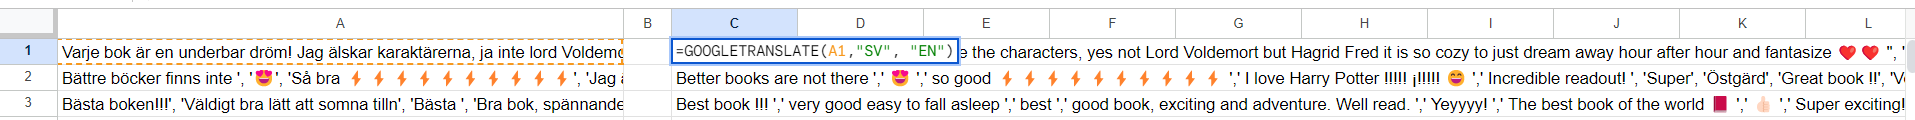

### Save English Cells as CSV
Then save the English cells to CSV file called "reviews_english.csv"

### Add English Reviews to the dataframe

In [37]:
df['reviews_en'] = pd.read_csv("reviews_english.csv").replace('#VALUE!', np.nan)

In [38]:
df['reviews_en']

0      Better books are not there ',' 😍 ',' so good ⚡...
1      Best book !!! ',' very good easy to fall aslee...
2      Good ',' It is so good and the others are also...
3      The Harry Potter series is among the best ever...
4      10/10 ',' Excellent! ',' I've always loved thi...
                             ...                        
145    Wonderful book! ',' Great series of books ',' ...
146    I WANT TO STAY IN THE REALM OF THE ELDERLING F...
147                                                  NaN
148    Good story and good end 😊 ',' The book is good...
149                                                  NaN
Name: reviews_en, Length: 150, dtype: object

# Sentiment Analysis

### `analyze_sentiment()`
This function analyzes a review, and then returns polarity scores.

For example, "This book is great, but it isn't my favorite." would return
- **Positive Sentiment:** 0.2
- **Negative Sentiment:** 0.252
- **Netural Sentiment:** 0.548
- **Compound Sentiment:** -0.1705

Which are used to give a numerical represetnation of the text.

In [82]:
def analyze_sentiment(text):
    """
    Analyze the sentiment of a given text using the SentimentIntensityAnalyzer from the nltk.sentiment.vader module.

    Args:
        text (str): The text to be analyzed for sentiment.

    Returns:
        tuple: A tuple of four sentiment scores: positive, negative, neutral, and compound.

    """
    # Instantiate a SentimentIntensityAnalyzer object
    analyzer = SentimentIntensityAnalyzer()

    # Call the polarity_scores method on the analyzer object, passing in the text to be analyzed
    scores = analyzer.polarity_scores(text)

    # Extract the positive, negative, neutral, and compound scores from the scores dictionary and return them as a tuple
    return scores['pos'], scores['neg'], scores['neu'], scores['compound']

(0.2, 0.252, 0.548, -0.1705)

In [83]:
analyze_sentiment("This book is great, but it isn't my favorite.")

(0.2, 0.252, 0.548, -0.1705)

## Calculate the `positive_sentiment`, `negative_sentiment`, `neutral_sentiment` and `compound_sentament` of all the reviews in each book.

In [52]:
# Fill missing values with empty strings
df['reviews_en'] = df['reviews_en'].fillna('')

# Apply the sentiment analysis function to every row of the 'english_reviews' column 
# and create new columns for each sentiment score
df[['positive_sentiment', 'negative_sentiment', 'neutral_sentiment', 'compound_sentament']] = df['reviews_en'].apply(analyze_sentiment).apply(pd.Series)

In [85]:
df.head(2)

,title,rating,description,reviews_se,url,reviews_en,positive_sentiment,negative_sentiment,neutral_sentiment,compound_sentament,compound_sentiment_ranking,rating_ranking
0,Harry Potter och Fenixorden,4.8,Harry Potter har fått nog. Sommarlovet hos Dur...,'Varje bok är en underbar dröm! Jag älskar kar...,https://www.bookbeat.se/bok/harry-potter-och-f...,"Better books are not there ',' 😍 ',' so good ⚡...",0.279,0.036,0.686,0.9939,32.5,13.0
1,Harry Potter and the Order of the Phoenix,4.8,'You are sharing the Dark Lord's thoughts and ...,"'Bättre böcker finns inte ', '😍', 'Så bra ⚡️⚡️...",https://www.bookbeat.se/bok/harry-potter-and-t...,"Best book !!! ',' very good easy to fall aslee...",0.549,0.000,0.451,0.9966,18.5,13.0


### Ranking the Ratings and Sentiment Values
We're ranking the ratings and compound sentiment values.

In [54]:
# rank the values in the compound_sentiment column
df['compound_sentiment_ranking'] = df['compound_sentament'].rank(ascending=False)

# rank the values in the rating column
df['rating_ranking'] = df['rating'].rank(ascending=False)

In [71]:
rankings = df.loc[:, ['title', 'compound_sentiment_ranking', 'rating_ranking', 'url']]

## Ranking by Ratings
Here we can see that it's basically Harry Potter and Game of Thrones on top.

In [78]:
rankings.sort_values(by=['rating_ranking'], ascending=True).head(7)

,title,compound_sentiment_ranking,rating_ranking,url
3,Harry Potter och Dödsrelikerna,51.5,2.0,https://www.bookbeat.se/bok/harry-potter-och-d...
4,Harry Potter and the Deathly Hallows,26.0,2.0,https://www.bookbeat.se/bok/harry-potter-and-t...
7,Harry Potter and the Half-Blood Prince,39.0,2.0,https://www.bookbeat.se/bok/harry-potter-and-t...
0,Harry Potter och Fenixorden,32.5,13.0,https://www.bookbeat.se/bok/harry-potter-och-f...
38,The Two Towers,42.0,13.0,https://www.bookbeat.se/bok/the-two-towers-569920
50,A game of thrones,142.0,13.0,https://www.bookbeat.se/bok/a-game-of-thrones-...
58,A storm of swords,90.0,13.0,https://www.bookbeat.se/bok/a-storm-of-swords-...


## Ranking by Compound Sentiment
However, when we rank order by compound sentiment, we see completely different books that might have a lower rating, but have much more positive reviews in the text, which might a truer sense of what books consumers would like.

In [79]:
rankings.sort_values(by=['compound_sentiment_ranking', 'rating_ranking'], ascending=True).head(7)

,title,compound_sentiment_ranking,rating_ranking,url
48,Farornas väg,1.0,99.5,https://www.bookbeat.se/bok/farornas-vag-19802
64,Glassvärdet,2.0,119.5,https://www.bookbeat.se/bok/glassvardet-208692
16,Ringens brödraskap,3.0,40.0,https://www.bookbeat.se/bok/ringens-brodraskap...
114,Before They Are Hanged,4.5,40.0,https://www.bookbeat.se/bok/before-they-are-ha...
95,Maze runner - I vansinnets öken,4.5,119.5,https://www.bookbeat.se/bok/maze-runner-i-vans...
22,Twilight - Om jag kunde drömma,6.0,62.5,https://www.bookbeat.se/bok/twilight-om-jag-ku...
32,Twilight 3 - Ljudet av ditt hjärta,7.5,62.5,https://www.bookbeat.se/bok/twilight-3-ljudet-...


In [81]:
# Looking at the first book for compound sentiment.
rankings.iloc[48]

title                                                           Farornas väg
compound_sentiment_ranking                                               1.0
rating_ranking                                                          99.5
url                           https://www.bookbeat.se/bok/farornas-vag-19802
Name: 48, dtype: object